<a href="https://colab.research.google.com/github/EthanMcFarlin/ait-deep-learning-assessment-6/blob/main/Ethan_AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [13]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [2]:
# The data— obtained from Gutenberg.org— consists of the full source text for two pieces of classic literature: Bram Stoker's 1897 novel "Dracula" 
# and Herman Melville's 1851 novel "Moby-Dick; or, The Whale".

# dracula: https://www.gutenberg.org/cache/epub/345/pg345.txt
# moby dick: https://www.gutenberg.org/files/2701/2701-0.txt

# Source text is read and saved to a local variable using the library urlopen
dracula = urlopen("https://www.gutenberg.org/cache/epub/345/pg345.txt").read().decode('utf-8').replace('\r\n', ' ')
moby_dick = urlopen("https://www.gutenberg.org/files/2701/2701-0.txt").read().decode('utf-8').replace('\r\n', ' ')


## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

Dracula Length: 865720
Moby Dick Length: 1238355


<Axes: >

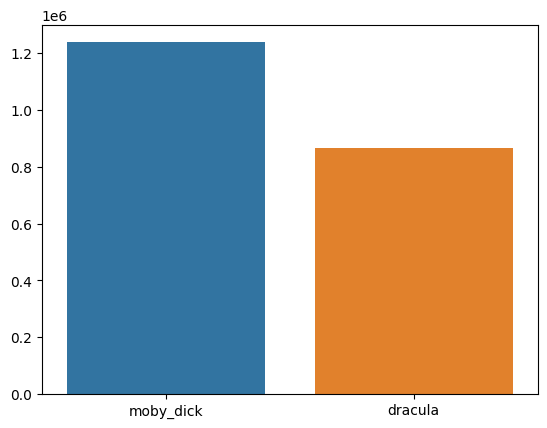

In [16]:
# Total length (in characters) of Dracula
dracula_len = sum(len(word) for word in dracula)
print("Dracula Length: " + str(dracula_len))

# Total length (in characters) of Moby Dick
moby_dick_len = sum(len(word) for word in moby_dick)
print("Moby Dick Length: " +  str(moby_dick_len))

# Visualization of text lengths using a Seaborn Counterplot
countplot_data = {"moby_dick": moby_dick_len, "dracula": dracula_len}
countplot_keys = list(countplot_data.keys())
countplot_values = [countplot_data[key] for key in countplot_keys]

# Data is stored in a Python dictionary
sns.barplot(x = countplot_keys, y = countplot_values)


## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [17]:
# Initializing the sequence length to 60
sequence_length = 60

# Sorting and counting distinct characters in either text
dracula_unique_characters = sorted(set(dracula))
moby_dick_unique_characters = sorted(set(moby_dick))
combined_unique_characters = sorted(set(dracula + moby_dick))
combined_unique_characters_length = len(combined_unique_characters)

# Building combined index to char and char to index dictionaries
char_indices = dict((c, i) for i, c in enumerate(combined_unique_characters))
indices_char = dict((i, c) for i, c in enumerate(combined_unique_characters))

# Initializing variables used in the one-hot encodings
dracula_sentences = []
moby_dick_sentences = []

# Extracting individual sentences from Dracula text using specified sequence length
for i in range(0, len(dracula), sequence_length):
    dracula_sentences.append(dracula[i : i + sequence_length])

# Extracting individual sentences from Moby Dick text using specified sequence length
for i in range(0, len(moby_dick), sequence_length):
    moby_dick_sentences.append(moby_dick[i : i + sequence_length])

# Combining separate sentences from the two texts into a combined data structure
combined_sentences = dracula_sentences + moby_dick_sentences
combined_sentences_length = len(combined_sentences)
print("Length of combined sentences: ", combined_sentences_length)

# Applying one-hot encoding to the input and target data
x = np.zeros((combined_sentences_length, sequence_length, combined_unique_characters_length), dtype = float)
y = np.zeros((combined_sentences_length, 1), dtype=float)

# Setting an offset to distinguish between membership of the two texts in the 3D NumPy array
index_offset = len(dracula_sentences)

# Setting the appropriate sequence label for Dracula— 1
for outer_index, sequence in enumerate(dracula_sentences):
    for inner_index, character in enumerate(sequence): 
        x[outer_index, inner_index, char_indices[character]] = 1
    y[outer_index][0] = 1

# Setting the appropriate sequence label for Moby Dick— 0
for outer_index, sequence in enumerate(moby_dick_sentences):
    for inner_index, character in enumerate(sequence): 
        x[outer_index + index_offset, inner_index, char_indices[character]] = 1
    y[outer_index + index_offset][0] = 0 


Length of combined sentences:  35069


## Data splitting
Split the data into train, validate and test sets. Make 

In [18]:
# Leveraging 'train_test_split' from 'sklearn.model_selection' to separate input and target data into test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15)

# Appyling the same technique to separate out a subset of the data into a validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [19]:
# Defining model structure
model = Sequential()

# Adding additional layers
model.add(Conv1D(filters=64, kernel_size=48, activation='relu', kernel_initializer='he_normal', input_shape=(sequence_length, combined_unique_characters_length), padding='same'))
model.add(Dense(1, activation="sigmoid"))
model.add(MaxPooling1D())
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.35))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

# Compiling and summarizing model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 60, 64)            347200    
                                                                 
 dense_6 (Dense)             (None, 60, 1)             65        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 30, 1)            0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 30, 1)             0         
                                                                 
 flatten_2 (Flatten)         (None, 30)                0         
                                                                 
 dense_7 (Dense)             (None, 128)               3968      
                                                      

## Model training
Train the model and apply early stopping.

In [20]:
# Applying early stopping from 'tensorflow.keras.callbacks'
es = EarlyStopping(patience = 10, restore_best_weights = True, monitor = "val_loss")

# Fitting the model to the data with 40 epochs
model.fit(x_train, y_train, 
          epochs=40, batch_size=32,
          validation_data = (x_val, y_val),
          callbacks= [es],
          verbose=2)

Epoch 1/40
746/746 - 63s - loss: 0.5555 - accuracy: 0.6996 - val_loss: 0.4559 - val_accuracy: 0.7880 - 63s/epoch - 84ms/step
Epoch 2/40
746/746 - 62s - loss: 0.4539 - accuracy: 0.7780 - val_loss: 0.4740 - val_accuracy: 0.7442 - 62s/epoch - 83ms/step
Epoch 3/40
746/746 - 60s - loss: 0.4127 - accuracy: 0.8037 - val_loss: 0.4108 - val_accuracy: 0.8074 - 60s/epoch - 81ms/step
Epoch 4/40
746/746 - 60s - loss: 0.3647 - accuracy: 0.8272 - val_loss: 0.4005 - val_accuracy: 0.8111 - 60s/epoch - 80ms/step
Epoch 5/40
746/746 - 62s - loss: 0.3135 - accuracy: 0.8567 - val_loss: 0.4408 - val_accuracy: 0.7739 - 62s/epoch - 83ms/step
Epoch 6/40
746/746 - 61s - loss: 0.2513 - accuracy: 0.8938 - val_loss: 0.4258 - val_accuracy: 0.8043 - 61s/epoch - 82ms/step
Epoch 7/40
746/746 - 66s - loss: 0.1861 - accuracy: 0.9258 - val_loss: 0.5164 - val_accuracy: 0.8121 - 66s/epoch - 88ms/step
Epoch 8/40
746/746 - 62s - loss: 0.1368 - accuracy: 0.9487 - val_loss: 0.5370 - val_accuracy: 0.8068 - 62s/epoch - 83ms/step


## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [21]:
# Evaluating and outputting the model performance
print("Model performance, in terms of loss (first value) and accuracy (second value): ", model.evaluate(x_test, y_test))

165/165 [==============================] - 4s 27ms/step - loss: 0.4050 - accuracy: 0.8052
Model performance, in terms of loss (first value) and accuracy (second value):  [0.4050202965736389, 0.8051701188087463]


## Confusion matrix
Calculate and display the confusion matrix.

165/165 [==============================] - 6s 34ms/step


<Axes: >

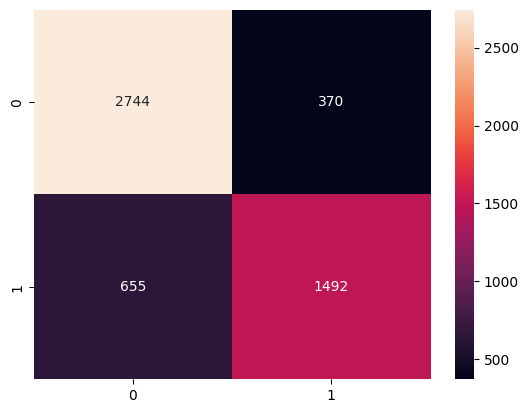

In [22]:
# Generating confusion matrix
conf = confusion_matrix(y_test, np.rint(model.predict(x_test)))

# Plotting confusion matrix using 'seaborn'
sns.heatmap(conf, annot= True, fmt='d')